In [94]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [95]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

In [96]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [97]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


(28, 28)


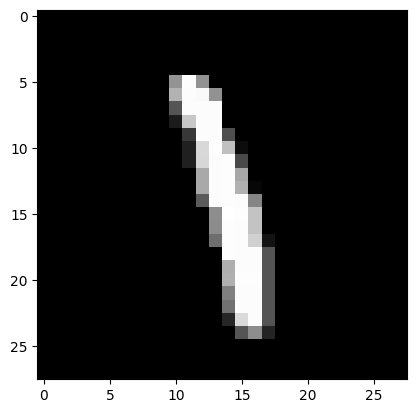

In [98]:
example_image = next(iter(training_data))[0].squeeze().numpy()
plt.imshow(example_image, cmap='gray')
print(example_image.shape)

Define CNN Model

In [99]:
def cnn_model():

    model = torch.nn.Sequential(
        torch.nn.Conv2d(
            in_channels=1, 
            out_channels=8, 
            kernel_size=(3, 3), 
            padding='same'
        ), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(
            in_channels=8, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding='same'
        ), 
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=(2,2)),

        torch.nn.Conv2d(
            in_channels=32, 
            out_channels=32, 
            kernel_size=(3, 3), 
            padding='same'
        ), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=(3, 3), 
            padding='same'
        ), 
        torch.nn.ReLU(),        
        torch.nn.MaxPool2d(kernel_size=(2,2)),

        torch.nn.Flatten(),
        torch.nn.Linear(int(64*(28/(2*2))**2), 10) # For numFilter=32: 64*7*7 = 3136; num_classes=10
    )

    return model

In [100]:
model = cnn_model()
from torchsummary import summary
summary(model, (1,28,28), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           2,336
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
              ReLU-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
          Flatten-11                 [-1, 3136]               0
           Linear-12                   [-1, 10]          31,370
Total params: 61,530
Trainable params: 61,530
Non-trainable params: 0
---------------------------------

In [101]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):

        ### YOUR CODE HERE ###
        # Training -----------------------------------------------------------------------------
        agg_loss_train = 0.0    # for cost calc at end of epoch
        agg_correct_train = 0.0 # for accuracy calc at end of epoch
        for batch, (X, Y) in enumerate(training_loader):
            # Actual training
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad() # reset gradient accumulation
            loss.backward() # compute gradient in back-prop
            optimizer.step()

            # Track loss and accuracy across batch
            agg_loss_train += loss.item()
            agg_correct_train += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost=agg_loss_train / len(training_loader.dataset)
        acc=agg_correct_train / len(training_loader.dataset)

        # Validation ----------------------------------------------------------------------------
        agg_loss_val = 0.0
        agg_correct_val = 0.0
        with torch.no_grad(): # won't be doing GD on these tensors, so turn off automatic tracking
            for X, Y in test_loader:
                pred = model(X) # pred.shape = (nbatch, 10)

                # Track loss and accuracy across batch
                agg_loss_val += cost_ce(pred, Y).item()
                agg_correct_val += (pred.argmax(dim=1) == Y).sum().item()

        # Update evaluation metrics
        cost_test = agg_loss_val / len(test_loader.dataset)
        acc_test = agg_correct_val / len(test_loader.dataset)

        if scheduler is not None:
            scheduler.step()
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

In [105]:
nepochs = 10
nbatch = 32
lr = 0.05

model = cnn_model() # reset model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True) 
test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

cost_train, cost_valid, acc_train, acc_valid = train_eval(model, optimizer, nepochs, training_loader, test_loader)

Epoch 0: 0.008348, 0.914080, 0.002179, 0.977600
Epoch 1: 0.001876, 0.982000, 0.002078, 0.980800
Epoch 2: 0.001355, 0.986240, 0.001610, 0.983200
Epoch 3: 0.001068, 0.989680, 0.001436, 0.986500
Epoch 4: 0.000886, 0.991560, 0.001278, 0.988100
Epoch 5: 0.000736, 0.992540, 0.001290, 0.987200
Epoch 6: 0.000612, 0.993760, 0.001543, 0.985900
Epoch 7: 0.000503, 0.994960, 0.001470, 0.985800
Epoch 8: 0.000472, 0.994960, 0.001551, 0.986500
Epoch 9: 0.000390, 0.996120, 0.001503, 0.986800


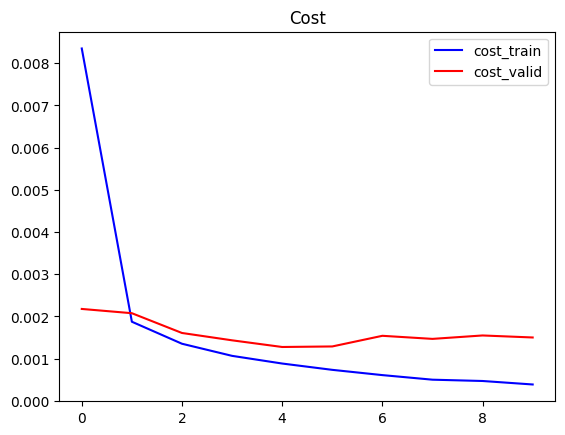

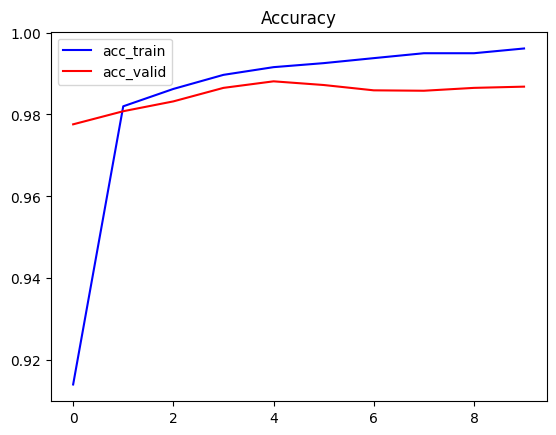

In [106]:
plt.figure(1)
plt.title("Cost")
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.legend()


plt.figure(2)
plt.title("Accuracy")
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_valid")
plt.legend()

## Implement Grad-Cam

In [107]:
def hook_store_A(module, input, output):
    module.A = output[0]
    
def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

In [108]:
layer = model[8]
layer.register_forward_hook(hook_store_A)
layer.register_backward_hook(hook_store_dydA)

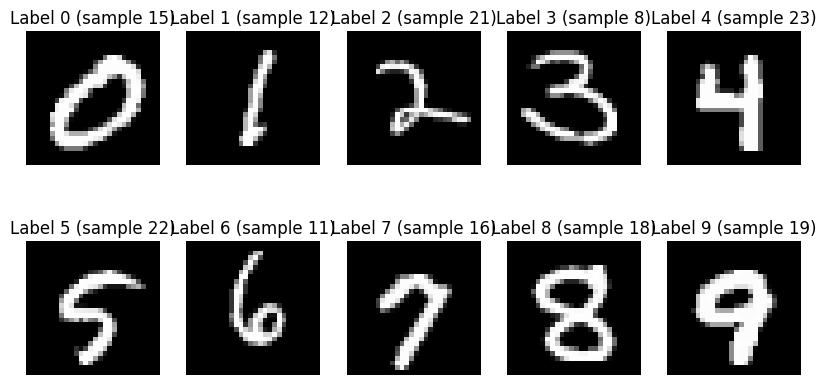

In [109]:
indices = np.zeros(10)
for idx, data in enumerate(training_data):
    indices[data[1]] = idx
    if (indices != 0).all():
        break
        
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
testimages = []
for i in range(1, cols * rows + 1):
    sample_idx = int(indices[i-1])
    img, label = training_data[sample_idx]
    testimages.append(img)
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

    


In [113]:
import torch.nn.functional as F
result = []
for ind, img in enumerate(testimages):
    img = img[None, :, :, :]
    output = model(img)
    
    c = ind
    output[0, c].backward()
    
    alpha = layer.dydA.mean((2, 3), keepdim = True)
    L = torch.relu((alpha * layer.A).sum(1, keepdim = True))
    
    L = torch.relu((alpha * layer.A).sum(1, keepdim = True))
    L = F.interpolate(L, size = (img.size(2), img.size(3)),
                        mode = 'bilinear', align_corners = False)
    
    result.append(L)

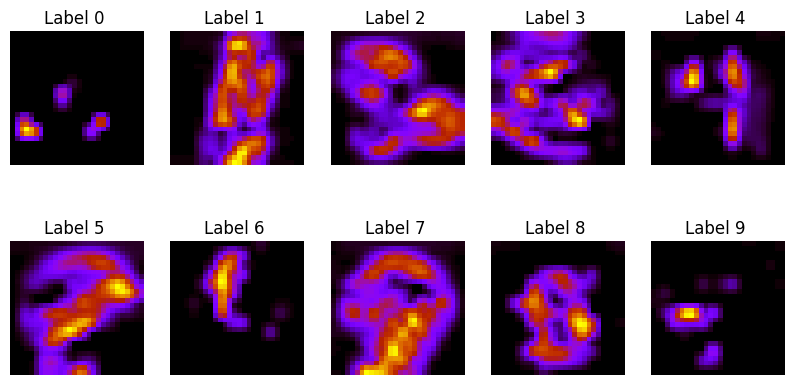

In [123]:
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img = result[i-1].detach()
    testimages.append(img)
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i "%(i-1))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gnuplot")
plt.show()

### Analysis
- 0, 6 and 9 the grad-CAM images have high peaks in small specific spots, indicating that only a few spots are relevant for detecting these digits.
- For 4 and 8 you can recognize the digit itself in the grad-CAM, meaning it detects the digits based on the white parts
- For 2 and 3 the Outlines of the digits are highlighted. So these digits are detected based on the transistions from white to black.
- 7 seems to be a combination of the effects from 2,3 and 4,8
- 5 and 1 are special cases. The grad-CAM of 5 is all over the place and it is hard to recognize the digit from the image. 1 on the other hand can be recognized but the region of high interest is bigger than the actual digit. 